# Setup

# Installation & Imports

In [ ]:
!pip install gdown

In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
"""
path = "/kaggle/accidents_dataset.csv"
print(path)

# Load dataset locally
original_dataset = pd.read_csv(path)
# List out dataset information
print(original_dataset.info())"""

'\npath = "/kaggle/accidents_dataset.csv"\nprint(path)\n\n# Load dataset locally\noriginal_dataset = pd.read_csv(path)\n# List out dataset information\nprint(original_dataset.info())'

In [ ]:
file_id = "1jEIJbMVmYRKu7nnTyyTB_lmxRzyfoy56"
dataset = "accidents_dataset.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset, quiet=False)

original_dataset = pd.read_csv(dataset)
print(original_dataset.info())

Downloading...
From: https://drive.google.com/uc?id=1jEIJbMVmYRKu7nnTyyTB_lmxRzyfoy56
To: /content/accidents_dataset.csv
100%|██████████| 4.30M/4.30M [00:00<00:00, 26.6MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

# Data Cleaning/Preprocessing

Goal is to remove all data points with incomplete information. This includes at least one feature that has an 'Unknown' value. Due to how large the uncleaned dataset is, removing data points rather than replacing feature values with an average is sufficient.

In [ ]:
print("Number of data points in uncleaned dataset:", original_dataset.shape[0])

uncleaned_data = original_dataset.copy()
incomplete_values = uncleaned_data[(uncleaned_data == 'Unknown').any(axis=1)].index
print("Number of data points with incomplete values ('Unknown'):", incomplete_values.shape[0])

uncleaned_data.drop(incomplete_values, inplace=True)
cleaned_data = uncleaned_data.copy()
print("Number of data points in cleaned data:", cleaned_data.shape[0])

Number of data points in uncleaned dataset: 12316
Number of data points with incomplete values ('Unknown'): 4726
Number of data points in cleaned data: 7590


In [ ]:
temp = cleaned_data.copy()

columns_numerical = [
    'Number_of_vehicles_involved', 'Number_of_casualties'
    ]

# Label encoding for columns with a ranking
columns_LE = [
    'Age_band_of_driver', 'Educational_level', 'Driving_experience',
    'Service_year_of_vehicle', 'Casualty_severity', 'Accident_severity'
    ]
labelEncoder = LabelEncoder()
for column in columns_LE:
    temp[column] = labelEncoder.fit_transform(temp[column])
print('Number of label encoded columns:', len(columns_LE))

# One hot encoding for nominal columns
nominal_columns = [
    col for col in temp.columns
    if col not in columns_LE + columns_numerical
    ]
ohe_df = pd.get_dummies(temp[nominal_columns])
print('Number of one hot encoded columns:', ohe_df.shape[1])
print("Accident severity classes:", labelEncoder.classes_)

# Combining LE and OHE into one dataset
temp = temp.drop(nominal_columns, axis=1)
encoded_dataset = pd.concat([ohe_df, temp], axis=1)

Number of label encoded columns: 6
Number of one hot encoded columns: 1140
Accident severity classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']


# Feature Reduction

In [ ]:
#Assign training and testing columns
target_col = 'Accident_severity'
y = encoded_dataset[target_col]
X = encoded_dataset.drop(columns=[target_col])

#Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

#Perform PCA for feature reduction
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)

#Convert data back into DataFrame
reduced_data = pd.DataFrame(reduced_data)

#Assign training and testing data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(reduced_data, y, test_size=0.2, random_state=46)

# Model

# Implementation

In [ ]:
#Model Implementation
model = LogisticRegression(solver='saga', max_iter=10000, C = 0.1)

model.fit(x_train, y_train)

LogisticRegression(C=0.1, max_iter=10000, solver='saga')

# Evaluation

Visualizations are a useful way to evaluate the model. The 3 visualizations implemented here offer valuable insights into why the model performs well or poorly and help us consider the next steps we must take for further improvement.

### Accuracy Heat Map

Accuracy: 0.8096179183135704
F1 Score (macro): 0.4991822749480234
ROC-AUC Score (macro): 0.7483182980666484


Text(0.5, 1.0, 'Accuracy Score: 0.8096179183135704')

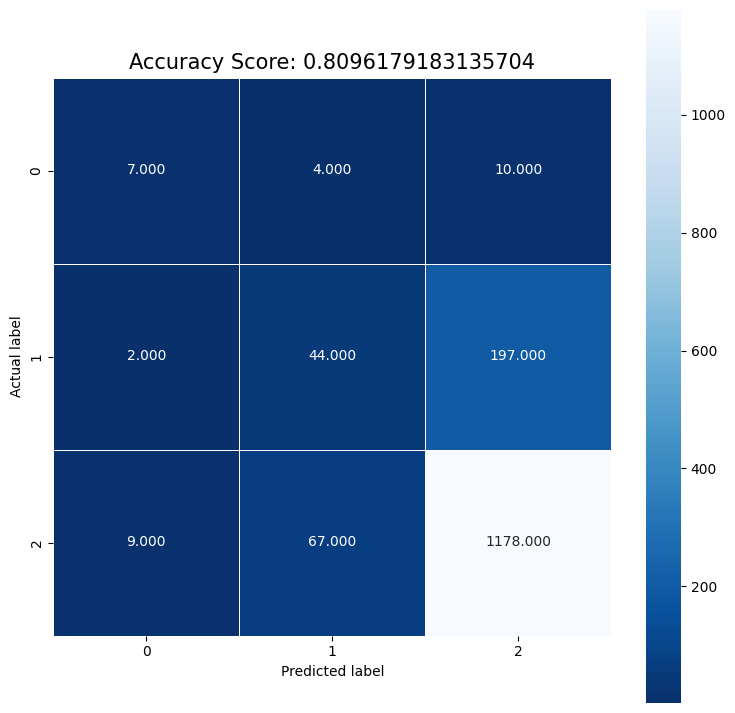

In [ ]:
# Accuracy Heat Map Visualization
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)
score = model.score(x_test, y_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
print(f"ROC-AUC Score (macro): {roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')}")


cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

This heat map reveals the model has an overall accuracy of about 81%, with the largest number of correct predictions being in the “Slight” category. The confusion matrix displays how many instances were correctly classified versus misclassified for each accident severity category. It seems to often confuse “Fatal” and “Serious” accidents for the “Slight” category, which indicates that the minority classes are not being distinguished as well as we would like. Looking at these facts together, it seems the model is better at dealing with the majority class effectively but tends to struggle more with the less common categories. It might be the case that there are many overlapping features between classes, making it hard for a linear model like logistic regression to clearly separate them.

### Scree Plot

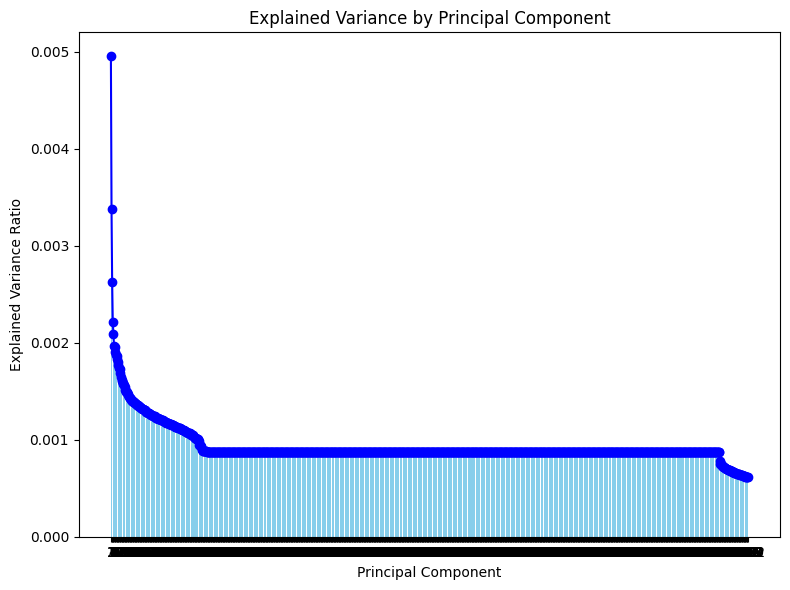

In [ ]:
# PC Variance Visualization
explained_variance = pca.explained_variance_ratio_
components = np.arange(1, len(explained_variance) + 1)

plt.figure(figsize=(8, 6))
plt.bar(components, explained_variance, color='skyblue')
plt.plot(components, explained_variance, marker='o', color='blue')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(components)
plt.tight_layout()
plt.show()

This scree plot shows the variance explained by each principal component, revealing that the first few principal components explain a super small fraction of the total variance each, since no single component is dominating. There is also no sharp elbow in the curve which could indicate the variance of this data is spread out across many dimensions. This means that capturing most of the variance requires a larger amount of principal components (rather than just one or two). With variance spread thinly across many components, it seems the PCA reduction might not have captured a small set of dominant features.

### Calibration Plot

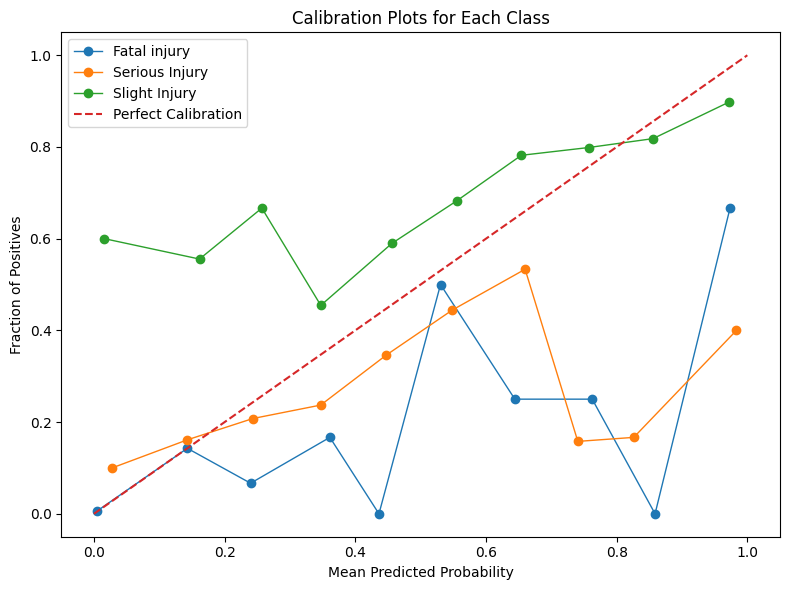

In [ ]:
# Class Calibration Plot Visualization
classes = np.unique(y_test)
plt.figure(figsize=(8, 6))

for cls in classes:
    y_test_binary = (y_test == cls).astype(int)
    y_prob_cls = model.predict_proba(x_test)[:, cls]
    prob_true, prob_pred = calibration_curve(y_test_binary, y_prob_cls, n_bins=10, pos_label=1)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=labelEncoder.classes_[cls])

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plots for Each Class")
plt.legend()
plt.tight_layout()
plt.show()

These calibration plots compare the predicted probabilities to the actual observed outcomes for each accident severity class. Unfortunately, none of the lines closely follow the diagonal - this suggests the model’s predicted probabilities are not calibrated as well as they could be. There are examples of both underestimation and overestimation at various probability levels. Miscalibration can happen because of the linear nature of logistic regression, (especially here, since we applied PCA), so it might not reveal the direct relationship between features and the target. This means that while the classification might be acceptable, the probabilities are off.